# Work Area

This Jupyter notebook is used to test small snippets of code - mainly for publishing on the [website blog](https://paulknewton.github.io/covid-ml/blog).

In [31]:
!curl -O https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  758k  100  758k    0     0  1393k      0 --:--:-- --:--:-- --:--:-- 1391k


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide.xlsx").set_index("dateRep")

In [33]:
df

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
dateRep,,,,,,,,,,
2020-05-12,12,5,2020,285,2,Afghanistan,AF,AFG,37172386.0,Asia
2020-05-11,11,5,2020,369,5,Afghanistan,AF,AFG,37172386.0,Asia
2020-05-10,10,5,2020,255,6,Afghanistan,AF,AFG,37172386.0,Asia
2020-05-09,9,5,2020,215,3,Afghanistan,AF,AFG,37172386.0,Asia
2020-05-08,8,5,2020,171,2,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...
2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


## Track the spread of the virus

Show how the virus moved to each country and established itself in the population (>= 100 cases)

In [158]:
# sum total of cases and deaths by country
cumsum_df = df.sort_index().reset_index().groupby(by=["countriesAndTerritories", "dateRep"])[["cases"]].sum().groupby(level=0).cumsum()

# threshold to be considered infected
threshold = 10
ordered_cases_df = cumsum_df[cumsum_df["cases"] >= threshold].reset_index(level=0)[["countriesAndTerritories", "cases"]].drop_duplicates(subset="countriesAndTerritories", keep="first").sort_index()

# group by month
ordered_cases_df["sequence"] = ordered_cases_df.index.to_period("M")
ordered_cases_df.head(10)

,countriesAndTerritories,cases,sequence
dateRep,,,
2019-12-31,China,27,2019-12
2020-01-28,Thailand,14,2020-01
2020-01-30,Singapore,10,2020-01
2020-01-30,Japan,11,2020-01
2020-02-01,Taiwan,10,2020-02
2020-02-01,South_Korea,12,2020-02
2020-02-02,Australia,11,2020-02
2020-02-03,United_States_of_America,11,2020-02
2020-02-04,Germany,11,2020-02


In [162]:
# 1. brew install geos proj gdal
# 2. download http://www.naturalearthdata.com/downloads/10m-cultural-vectors/
# 3. ogr2ogr -simplify .05 -lco ENCODING=UTF-8 countries/ ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp
import geopandas as gpd

# world map
world = gpd.read_file("countries/ne_10m_admin_0_countries_lakes.shp")

# clean data: rename japan
ordered_cases_df.loc[(ordered_cases_df["countriesAndTerritories"] == "Cases_on_an_international_conveyance_Japan"), "countriesAndTerritories"] = "Japan"

# clean data: replace underscores with spaces
ordered_cases_df["countriesAndTerritories"] = ordered_cases_df["countriesAndTerritories"].str.replace("_", " ")

# merge into world map data
for_plotting = world.merge(ordered_cases_df, how="right", left_on = "SOVEREIGNT", right_on = "countriesAndTerritories").sort_values("sequence")

# show any countries that could not be matched in the map data (ordered by cases)
errors = len(for_plotting[for_plotting["SOVEREIGNT"].isnull()])
if errors:
    print("Warning: Could not find %d countries from %d" % (errors, len(ordered_cases_df)))
for_plotting[for_plotting["SOVEREIGNT"].isnull()][["countriesAndTerritories", "cases"]].sort_values("cases", ascending=False)

,countriesAndTerritories,cases
224,Faroe Islands,72
235,Puerto Rico,64
237,Congo,19
221,Serbia,18
249,Timor Leste,18
230,United States Virgin Islands,17
229,Guernsey,17
241,Sint Maarten,16
219,Palestine,16
242,Guinea Bissau,15


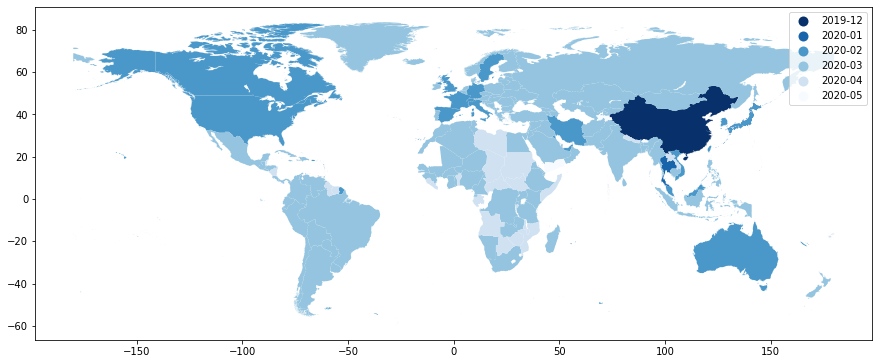

In [184]:
ax = for_plotting.plot(column="sequence", figsize=(15,9), cmap="Blues_r", legend=True)
plt.savefig("docs/graphs/rates/Spread_across_the_world.png")

In [11]:
# helper function to plot selected countries
def plot_over_time(y, title, filename):
    for log_scaling, title_suffix, file_suffix in [(False, "", ""), (True, " with logarithmic scale", "_with_logarithmic_scale")]:
        ax = None
        for c in countries:
            # transform daily delta into cumulative
            df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()

            ax = df_c.plot(ax=ax, y=y, title=title + title_suffix, logy=log_scaling)

        ax.set_ylabel(y)
        ax.legend(countries)
        plt.tight_layout()
        plt.savefig(filename + file_suffix + ".png")

## Normal distribution

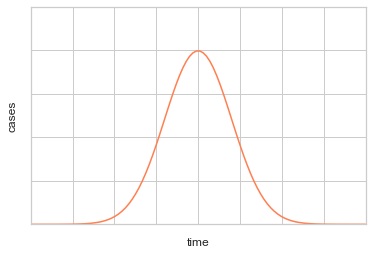

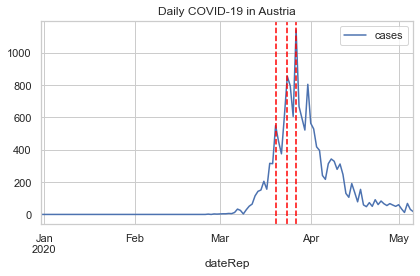

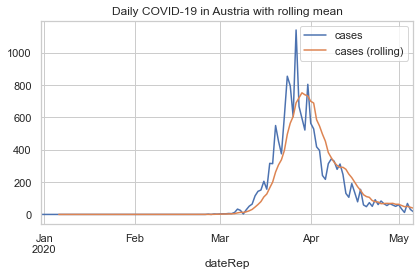

In [52]:
sns.set(style="whitegrid")

import scipy
x_min = 0
x_max = 20
mean = 10
std = 2.0
x = np.linspace(x_min, x_max, 100)
y = scipy.stats.norm.pdf(x,mean,std)
plt.plot(x,y, color='coral')
plt.xlim(0, 20)
plt.ylim(0,0.25)
ax = plt.gca()
plt.xlabel("time")
plt.ylabel("cases")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.savefig("docs/img/normal_dist.png")
plt.show()

df_austria = df[df["countriesAndTerritories"] == "Austria"][["cases"]].sort_index()
df_austria.plot(title="Daily COVID-19 in Austria")

for d in ["2020-03-20", "2020-03-24", "2020-03-27" ]:
    plt.axvline(pd.to_datetime(d), color="red", linestyle="--")
plt.tight_layout()
plt.savefig("docs/img/austria_multiple_peaks.png")

# 5 day rolling mean to smooth curve
ax = df_austria.plot(title="Daily COVID-19 in Austria with rolling mean")
df_rolling = df_austria.rolling(7).mean().rename({"cases": "cases (rolling)"}, axis="columns")
df_rolling.plot(ax=ax, legend=True)
plt.tight_layout()
plt.savefig("docs/img/austria_rolling.png")
